<a href="https://colab.research.google.com/github/Dominickstephens/aLoRa/blob/main/Roberta_Emotions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning of Pretrained LLMs
## Mark Langtry & Dominick Stephens
### 22340475 & 22343288

For this project we are using the Roberta Model to classify the Go Emotions dataset. We are fin tuning this using full fine tuning, Lora, Lora+, AdaLora, and Dora. We will the analyse these different fine tuning methods to evaluate and contrast these methods.

In [10]:
!pip install transformers datasets accelerate evaluate pynvml optuna
!pip install -U peft
!pip install -U bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 9.4 MB/s eta 0:00:00


# Imports for all the code and general configuration from training

Most Hyperparamaters are from general reccomendations from their papers, learning rate was optimised using Optuna

In [11]:
from datasets import load_dataset
from transformers import RobertaTokenizer, RobertaForSequenceClassification, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType, AdaLoraConfig
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.optim import AdamW
from tqdm import tqdm
import torch
import numpy as np
import evaluate
import time
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from pynvml import *
import optuna



# Configuration
MODEL_NAME = "roberta-base"
NUM_LABELS = 28
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
EPOCHS = 3
LEARNING_RATE = 5e-5
FF_LEARNING_RATE = 1e-5
BATCH_SIZE = 16
# https://arxiv.org/pdf/2412.12148
THRESHOLD = 0.5

# Dataset and Tokeniser

Here we load our dataset 'Go Emotions' from Google.

In [3]:
# Load the dataset
ds = load_dataset("google-research-datasets/go_emotions", "simplified")

# Tokenizer
tokenizer = RobertaTokenizer.from_pretrained(MODEL_NAME)
max_length = 128

def tokenize(batch):
    encodings = tokenizer(batch['text'], truncation=True, padding='max_length', max_length=max_length)
    encodings['labels'] = batch['labels']
    return encodings

ds_encoded = ds.map(tokenize, batched=True)
ds_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

def collate_fn(batch):
    input_ids = torch.stack([item['input_ids'] for item in batch])
    attention_mask = torch.stack([item['attention_mask'] for item in batch])

    labels = []
    for item in batch:
        multi_hot = torch.zeros(NUM_LABELS, dtype=torch.float)
        if item['labels'] is not None:
            for l in item['labels']:
                if 0 <= l < NUM_LABELS:
                    multi_hot[l] = 1.0
        labels.append(multi_hot)

    labels = torch.stack(labels)
    return {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': labels}

# Data Loaders
train_loader = DataLoader(ds_encoded['train'], batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(ds_encoded['validation'], batch_size=BATCH_SIZE, collate_fn=collate_fn)

# Evaluation Metric
f1_metric = evaluate.load("f1", config="multilabel")

README.md: 0.00B [00:00, ?B/s]

simplified/train-00000-of-00001.parquet:   0%|          | 0.00/2.77M [00:00<?, ?B/s]

simplified/validation-00000-of-00001.par(…):   0%|          | 0.00/350k [00:00<?, ?B/s]

simplified/test-00000-of-00001.parquet:   0%|          | 0.00/347k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/43410 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5426 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5427 [00:00<?, ? examples/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

Map:   0%|          | 0/43410 [00:00<?, ? examples/s]

Map:   0%|          | 0/5426 [00:00<?, ? examples/s]

Map:   0%|          | 0/5427 [00:00<?, ? examples/s]

# Preparing the Model

Here is our general function to load the desired fine tuning method through the form of a string input. Here we use PEFT to load the Lora model and its varient into the Roberta Model. this one function for all the methods makes it easy to extend the functionality and to include another LoRA varient

In [4]:
def prepare_model(method: str):
    """
    Prepares a RoBERTa model for fine-tuning using different PEFT strategies:
    - "Full"      : full fine-tuning
    - "LoRA"      : standard LoRA
    - "LoRA+"     : LoRA with Rescaled Stable adaptation
    - "AdaLoRA"   : Adaptive LoRA (dynamic rank allocation)
    - "DoRA"      : Weight-decomposed LoRA (Meta 2024)
    - "QLoRA"     : 4-bit quantized LoRA
    """

    # Load Quantization Config
    quantization_config = None
    if method == "QLoRA":
        quantization_config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_quant_type="nf4",
            bnb_4bit_use_double_quant=True,
            bnb_4bit_compute_dtype=torch.bfloat16,
        )

    # Load base RoBERTa
    model = RobertaForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification",
        quantization_config=quantization_config,
        device_map="auto" if method == "QLoRA" else None,
    )

    # Choose PEFT variant
    if method == "LoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"],
        )
        model = get_peft_model(model, config)
        print("\nUsing LoRA")

    elif method == "LoRA+":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"],
            use_rslora=True,  # LoRA+
        )
        model = get_peft_model(model, config)
        print("\n⚙️ Using LoRA+")

    elif method == "AdaLoRA":
        config = AdaLoraConfig(
            task_type=TaskType.SEQ_CLS,
            init_r=8,
            target_r=4,
            tinit=100,
            tfinal=500,
            deltaT=10,
            lora_alpha=32,
            lora_dropout=0.1,
            total_step=len(train_loader) * EPOCHS
        )
        model = get_peft_model(model, config)
        print("\nUsing AdaLoRA")

    elif method == "DoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=32,
            lora_dropout=0.1,
            target_modules=["query", "value"],
            use_dora=True,  # enables DoRA
        )
        model = get_peft_model(model, config)
        print("\nUsing DoRA")

    elif method == "QLoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=8,
            lora_alpha=16,
            lora_dropout=0.1,
            target_modules=["query", "value"],
        )
        model = get_peft_model(model, config)
        print("\nUsing QLoRA (4-bit quantized + LoRA)")

    else:
        print("\nFull Fine-Tuning (no adapters)")
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        total_params = sum(p.numel() for p in model.parameters())
        print(f"Total Parameters: {total_params / 1e6:.2f}M")
        print(f"Trainable Parameters: {trainable_params / 1e6:.2f}M (100%)")
        model.to(DEVICE)
        optimizer = AdamW(model.parameters(), lr=FF_LEARNING_RATE)
        return model, optimizer

    # Shared setup for PEFT variants
    model.print_trainable_parameters()
    model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)
    return model, optimizer


# Train the Model

Here we iterate through the desired epochs to fine tune the model accoridng to the required method. pynvml is used to capture GPU statistics. All metrics recorded are stored in the dictionary of results and this is the output of this function along with the trained model. After Training it is possible to save a checkpoint of the model, this allows us to just run the evaluation without having to train the model again

In [5]:
def train_model(model, optimizer, method: str, train_loader, device, epochs, save_model):
    results = {}
    start_time = time.time()

    gpu_utilization_history = []
    max_gpu_mem_allocated = 0.0

    if device.type == 'cuda':
        nvmlInit()
        handle = nvmlDeviceGetHandleByIndex(device.index if device.index is not None else 0)

    model.train()
    for epoch in range(epochs):
        loop = tqdm(train_loader, leave=True, desc=f"{method} Epoch {epoch+1}")
        for batch in loop:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()
            if device.type == 'cuda':
                util = nvmlDeviceGetUtilizationRates(handle)
                gpu_util_percent = util.gpu
                gpu_utilization_history.append(gpu_util_percent)

                allocated_mem_bytes = torch.cuda.memory_allocated(device)

                max_gpu_mem_allocated = max(max_gpu_mem_allocated, allocated_mem_bytes / (1024**3))

                loop.set_postfix(
                    loss=loss.item(),
                    gpu_util_perc=f"{gpu_util_percent}%",
                    gpu_mem_gb=f"{allocated_mem_bytes / (1024**3):.2f}"
                )
            else:
                loop.set_postfix(loss=loss.item())

    total_train_time = time.time() - start_time
    results['train_time_sec'] = total_train_time

    if device.type == 'cuda':
        results['max_gpu_mem_gb'] = max_gpu_mem_allocated
        results['max_gpu_percent'] = max(gpu_utilization_history) if gpu_utilization_history else 0
        results['average_gpu_percent'] = sum(gpu_utilization_history) / len(gpu_utilization_history) if gpu_utilization_history else 0

        nvmlShutdown()


    if save_model:
      cpt_str = method + "_checkpoint.pth"
      torch.save({
      'epoch': epoch,
      'model_state_dict': model.state_dict(),
      'optimizer_state_dict': optimizer.state_dict(),
      'loss': loss,
      }, cpt_str)

    return model, results

#Evaluting The Model

Since Go emotions is a multiclass and multilabel dataset with a high varience of samples for each label. We use metrics such as F1 Score, Hamming Loss, and ROC AUC Score, to fully capture the effectiveness of the system. These metrics are added to the dictioanry of results for comparisons later

In [6]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
    hamming_loss,
    roc_auc_score,
    average_precision_score
)

def evaluate_model(model, val_loader, f1_metric, threshold, device, method: str):
    model.eval()
    all_preds, all_targets, all_probs = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits

            pred_probs = torch.sigmoid(logits)
            pred_labels = (pred_probs > threshold).long()

            all_probs.append(pred_probs.cpu().numpy())
            all_preds.append(pred_labels.cpu().numpy())
            all_targets.append(labels.long().cpu().numpy())

    preds = np.concatenate(all_preds, axis=0)
    probs = np.concatenate(all_probs, axis=0)
    targets = np.concatenate(all_targets, axis=0)

    # Multi-label metrics
    results = {
        "f1_macro": f1_score(targets, preds, average="macro"),
        "f1_micro": f1_score(targets, preds, average="micro"),
        "f1_weighted": f1_score(targets, preds, average="weighted"),
        "precision_macro": precision_score(targets, preds, average="macro", zero_division=0),
        "recall_macro": recall_score(targets, preds, average="macro", zero_division=0),
        "hamming_loss": hamming_loss(targets, preds),
        "exact_match_accuracy": np.mean([np.all(p == t) for p, t in zip(preds, targets)]),
    }

    # Probabilistic metrics (optional)
    try:
        results["roc_auc_macro"] = roc_auc_score(targets, probs, average="macro")
        results["pr_auc_macro"] = average_precision_score(targets, probs, average="macro")
    except ValueError:
        results["roc_auc_macro"] = None
        results["pr_auc_macro"] = None

    print("-" * 50)
    print(f"| {method} Evaluation Results |")
    print("-" * 50)
    for k, v in results.items():
        if v is not None:
            print(f"{k.replace('_',' ').title():30}: {v:.4f}")
    print("-" * 50)

    return results


# CleanUp

Deleting the model after it is finished being used is important to keep as much ram available in the gpu and to avoid out of memory errors, and for best practices.

In [7]:
def cleanup(full_model=None, full_optimizer=None):
    if full_model is not None:
        del full_model
    if full_optimizer is not None:
        del full_optimizer
    if torch.cuda.is_available():
        torch.cuda.empty_cache()

# Evaluation before Fientuning

This acts as a baseline for our model before any finetuning takes place, poor results are expected as the model has not been trained to complete this task. Hence the need for the further finetuning

In [8]:
results_table = []

print("Before FINE-TUNING")
print("="*60)
full_model, full_optimizer = prepare_model("Full Fine-Tuning")

# Evaluate
print("\nEvaluating model before training...")
pretrain_eval = evaluate_model(
    full_model,
    val_loader,
    f1_metric,
    THRESHOLD,
    DEVICE,
    "Full Fine-Tuning (Before Training)"
)

before_results = {"train_time_sec": 0.0, **pretrain_eval}
results_table.append({"Method": "Before Training", **before_results})

cleanup(full_model, full_optimizer)


Before FINE-TUNING


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Full Fine-Tuning (no adapters)
Total Parameters: 124.67M
Trainable Parameters: 124.67M (100%)

Evaluating model before training...
--------------------------------------------------
| Full Fine-Tuning (Before Training) Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0313
F1 Micro                      : 0.0492
F1 Weighted                   : 0.0281
Precision Macro               : 0.0164
Recall Macro                  : 0.5608
Hamming Loss                  : 0.5714
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.4999
Pr Auc Macro                  : 0.0435
--------------------------------------------------


# Evaluting Full Fine Tuning

This is the evaluation of updating all the weights of the Roberta model. The roberta model contains 124.67 M paramters. Each of these will be updated through this process


In [14]:
full_method = "Full Fine-Tuning"

full_model, full_optimizer = prepare_model(full_method)

train_full_model = True

if (train_full_model):
  # Train
  full_model, full_train_results = train_model(
      full_model,
      full_optimizer,
      full_method,
      train_loader,
      DEVICE,
      EPOCHS,
      save_model=True
  )
else:
  # Load checkpoint
  cpt_string = full_method + "_checkpoint.pth"
  checkpoint = torch.load(cpt_string)
  full_model.load_state_dict(checkpoint['model_state_dict'])
  full_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  results = {}
  results['train_time_sec'] = 0



# Evaluate
full_eval_results = evaluate_model(
    full_model,
    val_loader,
    f1_metric,
    THRESHOLD,
    DEVICE,
    full_method
)

full_results = {**full_train_results, **full_eval_results}
results_table.append({"Method": "Full Fine-Tuning", **full_results})

cleanup(full_model, full_optimizer)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Full Fine-Tuning (no adapters)
Total Parameters: 124.67M
Trainable Parameters: 124.67M (100%)


Full Fine-Tuning Epoch 3: 100%|██████████| 2714/2714 [03:49<00:00, 11.81it/s, gpu_mem_gb=1.90, gpu_util_perc=95%, loss=0.106]


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.4373
F1 Micro                      : 0.5597
F1 Weighted                   : 0.5377
Precision Macro               : 0.5612
Recall Macro                  : 0.3881
Hamming Loss                  : 0.0315
Exact Match Accuracy          : 0.4373
Roc Auc Macro                 : 0.9234
Pr Auc Macro                  : 0.5012
--------------------------------------------------


In [ ]:
# del lora_model
# del lora_optimizer
# torch.cuda.empty_cache()

# Evalute Lora and its Varients

We will now use parameter efficent fine tuning to learn the dataset and then subsequently evaluted. Since it is not updating all the weights, the training times are reduced and the percentage of trainable parameters will be greatly reduced. After each of the training, our comparison of results is printed

In [16]:
# ============================================================
# LoRA / QLoRA / AdaLoRA / DoRA BENCHMARK
# ============================================================

methods_to_run = ["LoRA","LoRA+","AdaLoRA", "DoRA"]
# results_table = []

for lora_method in methods_to_run:
    print("\n" + "="*70)
    print(f"Starting Fine-Tuning with {lora_method}")
    print("="*70)

    train_lora_model = True

    # ---- Prepare model and optimizer ----
    try:
        lora_model, lora_optimizer = prepare_model(lora_method)
    except Exception as e:
        print(f"Failed to prepare {lora_method}: {e}")
        continue

    if train_lora_model:
        # ---- Train ----
        try:
            lora_model, lora_train_results = train_model(
                lora_model,
                lora_optimizer,
                lora_method,
                train_loader,
                DEVICE,
                EPOCHS,
                save_model=True
            )
        except torch.cuda.OutOfMemoryError:
            print(f"Skipping {lora_method} (Out of memory)")
            torch.cuda.empty_cache()
            continue
        except Exception as e:
            print(f"Training failed for {lora_method}: {e}")
            continue

    else:
        # ---- Load checkpoint ----
        cpt_string = f"{lora_method}_checkpoint.pth"
        checkpoint = torch.load(cpt_string)
        lora_model.load_state_dict(checkpoint["model_state_dict"])
        lora_optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        epoch = checkpoint["epoch"]
        loss = checkpoint["loss"]
        lora_train_results = {"train_time_sec": 0, "final_loss": loss}

    # ---- Evaluate ----
    try:
        lora_eval_results = evaluate_model(
            lora_model,
            val_loader,
            f1_metric,
            THRESHOLD,
            DEVICE,
            lora_method
        )
    except Exception as e:
        print(f"Evaluation failed for {lora_method}: {e}")
        continue

    # ---- Merge and store results ----
    lora_results = {**lora_train_results, **lora_eval_results}
    results_table.append({"Method": lora_method, **lora_results})

    # ---- Cleanup GPU memory ----
    del lora_model
    del lora_optimizer
    torch.cuda.empty_cache()

print("\n" + "="*70)
print("ALL EXPERIMENTS COMPLETE")
print("="*70)

# Convert to DataFrame for nice display (optional)
import pandas as pd
results_df = pd.DataFrame(results_table)
display(results_df)



Starting Fine-Tuning with LoRA


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using LoRA
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 3: 100%|██████████| 2714/2714 [02:34<00:00, 17.53it/s, gpu_mem_gb=2.85, gpu_util_perc=90%, loss=0.0617]


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.4073
F1 Micro                      : 0.5450
F1 Weighted                   : 0.5098
Precision Macro               : 0.6270
Recall Macro                  : 0.3466
Hamming Loss                  : 0.0309
Exact Match Accuracy          : 0.4090
Roc Auc Macro                 : 0.9289
Pr Auc Macro                  : 0.4937
--------------------------------------------------

Starting Fine-Tuning with LoRA+


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



⚙️ Using LoRA+
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA+ Epoch 3: 100%|██████████| 2714/2714 [02:35<00:00, 17.49it/s, gpu_mem_gb=2.85, gpu_util_perc=92%, loss=0.104]


--------------------------------------------------
| LoRA+ Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.4313
F1 Micro                      : 0.5598
F1 Weighted                   : 0.5219
Precision Macro               : 0.6653
Recall Macro                  : 0.3763
Hamming Loss                  : 0.0307
Exact Match Accuracy          : 0.4261
Roc Auc Macro                 : 0.9325
Pr Auc Macro                  : 0.5025
--------------------------------------------------

Starting Fine-Tuning with AdaLoRA


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using AdaLoRA
trainable params: 1,939,804 || all params: 126,607,040 || trainable%: 1.5321


AdaLoRA Epoch 3: 100%|██████████| 2714/2714 [05:53<00:00,  7.67it/s, gpu_mem_gb=2.87, gpu_util_perc=64%, loss=0.0399]


--------------------------------------------------
| AdaLoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.3663
F1 Micro                      : 0.5426
F1 Weighted                   : 0.5006
Precision Macro               : 0.6333
Recall Macro                  : 0.3053
Hamming Loss                  : 0.0309
Exact Match Accuracy          : 0.4077
Roc Auc Macro                 : 0.9253
Pr Auc Macro                  : 0.4805
--------------------------------------------------

Starting Fine-Tuning with DoRA


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Using DoRA
trainable params: 925,468 || all params: 125,592,632 || trainable%: 0.7369


DoRA Epoch 3: 100%|██████████| 2714/2714 [03:07<00:00, 14.48it/s, gpu_mem_gb=3.34, gpu_util_perc=77%, loss=0.0679]


--------------------------------------------------
| DoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.4057
F1 Micro                      : 0.5526
F1 Weighted                   : 0.5147
Precision Macro               : 0.6195
Recall Macro                  : 0.3495
Hamming Loss                  : 0.0308
Exact Match Accuracy          : 0.4185
Roc Auc Macro                 : 0.9313
Pr Auc Macro                  : 0.5007
--------------------------------------------------

ALL EXPERIMENTS COMPLETE


,Method,train_time_sec,f1_macro,f1_micro,f1_weighted,precision_macro,recall_macro,hamming_loss,exact_match_accuracy,roc_auc_macro,pr_auc_macro,max_gpu_mem_gb,max_gpu_percent,average_gpu_percent
0,Before Training,0.000000,0.031336,0.049220,0.028081,0.016405,0.560837,0.571389,0.000000,0.499891,0.043515,NaN,NaN,NaN
1,Full Fine-Tuning,691.676963,0.437260,0.559669,0.537745,0.561219,0.388125,0.031475,0.437339,0.923370,0.501194,1.896698,96.0,93.528371
2,LoRA,464.479632,0.407333,0.544978,0.509768,0.627047,0.346610,0.030863,0.408957,0.928870,0.493714,2.851894,94.0,91.889094
3,LoRA+,465.308446,0.431317,0.559796,0.521859,0.665284,0.376255,0.030672,0.426097,0.932470,0.502461,2.851894,94.0,91.767502
4,AdaLoRA,1045.878520,0.366332,0.542640,0.500628,0.633265,0.305314,0.030923,0.407667,0.925261,0.480478,2.868149,75.0,64.596414
5,DoRA,563.200773,0.405711,0.552581,0.514655,0.619498,0.349500,0.030804,0.418540,0.931339,0.500676,3.340827,95.0,92.204618


In [24]:
print(results_table)

[{'Method': 'Before Training', 'train_time_sec': 0.0, 'f1_macro': 0.031335920305033696, 'f1_micro': 0.04922018750547621, 'f1_weighted': 0.02808050153872728, 'precision_macro': 0.016405070599173906, 'recall_macro': 0.5608372599392119, 'hamming_loss': 0.5713890790374387, 'exact_match_accuracy': np.float64(0.0), 'roc_auc_macro': np.float64(0.4998908269302892), 'pr_auc_macro': np.float64(0.04351488009613492)}, {'Method': 'Full Fine-Tuning', 'train_time_sec': 691.676962852478, 'max_gpu_mem_gb': 1.8966984748840332, 'max_gpu_percent': 96, 'average_gpu_percent': 93.52837140751659, 'f1_macro': 0.43725979398156817, 'f1_micro': 0.5596685082872929, 'f1_weighted': 0.5377453506853758, 'precision_macro': 0.5612192968180576, 'recall_macro': 0.38812518372722843, 'hamming_loss': 0.031475435732715495, 'exact_match_accuracy': np.float64(0.43733873940287504), 'roc_auc_macro': np.float64(0.923369949134919), 'pr_auc_macro': np.float64(0.5011939758569485)}, {'Method': 'LoRA', 'train_time_sec': 464.47963237762

In [25]:
params = [0,124670000, 907036, 907036, 1939804,925468]

for result, param in zip(results_table, params):
    # Add the new key 'trainable_params' to the current dictionary (result)
    result['trainable_params'] = param

In [26]:
print("\n\nCOMPARISON OF RESULTS")
print("#" * 100)

# Print table header with new metrics
print(f"| {'Method':<20} | {'Trainable Params (M)':<20} | {'Train Time (s)':<15} | "
      f"{'Macro F1':<10} | {'Hamming Loss':<10} | {'Roc Auc':<10} |")
print("-" * 100)

# Print each row from results_table
for result in results_table:
    method_name = result["Method"]
    trainable_params = result.get("trainable_params", 0.0)
    train_time = result.get("train_time_sec", 0.0)
    f1_macro = result.get("f1_macro", 0.0)
    # accuracy = result.get("accuracy", 0.0)
    hamming = result.get("hamming_loss", 0.0)
    roc_auc = result.get("roc_auc_macro", 0.0)

    print(f"| {method_name:<20} | {trainable_params / 1e6:<20.4f} | {train_time:<15.2f} | "
          f"{f1_macro:<10.4f} | {hamming:<10.4f} | {roc_auc:<10.4f} |")

print("#" * 100)





COMPARISON OF RESULTS
####################################################################################################
| Method               | Trainable Params (M) | Train Time (s)  | Macro F1   | Hamming Loss | Roc Auc    |
----------------------------------------------------------------------------------------------------
| Before Training      | 0.0000               | 0.00            | 0.0313     | 0.5714     | 0.4999     |
| Full Fine-Tuning     | 124.6700             | 691.68          | 0.4373     | 0.0315     | 0.9234     |
| LoRA                 | 0.9070               | 464.48          | 0.4073     | 0.0309     | 0.9289     |
| LoRA+                | 0.9070               | 465.31          | 0.4313     | 0.0307     | 0.9325     |
| AdaLoRA              | 1.9398               | 1045.88         | 0.3663     | 0.0309     | 0.9253     |
| DoRA                 | 0.9255               | 563.20          | 0.4057     | 0.0308     | 0.9313     |
#####################################

# Plotting

Here we plot the Key metrics aginst each other to evaluate and compare the various finetuning methods.
The graphs are as follows:

- Training Time vs F1
- \# Parameters vs F1
- ROC AUC vs Training Time
- PR AUC vs F1 Macro
- Hamming Loss vs F1
- Radar Chart (Multi-Metric Comparison)


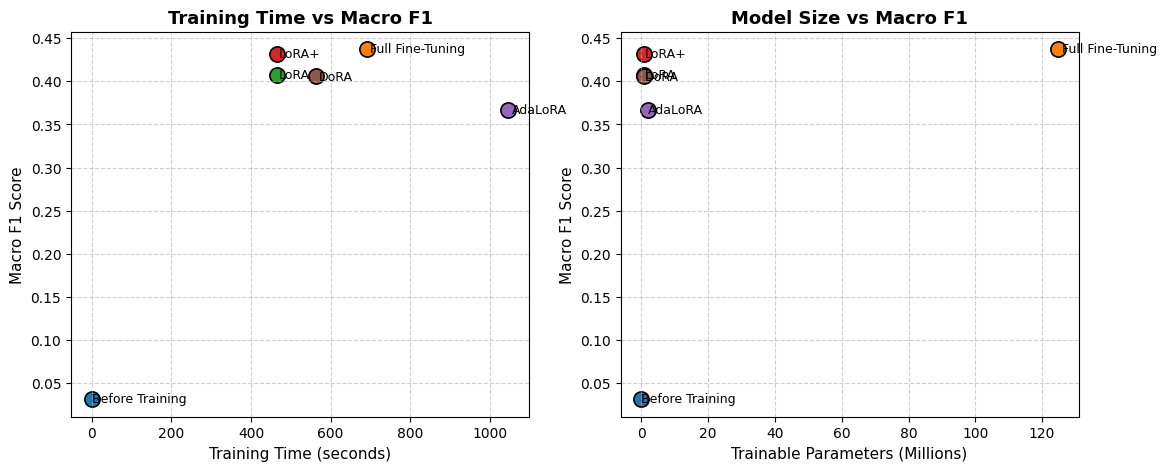

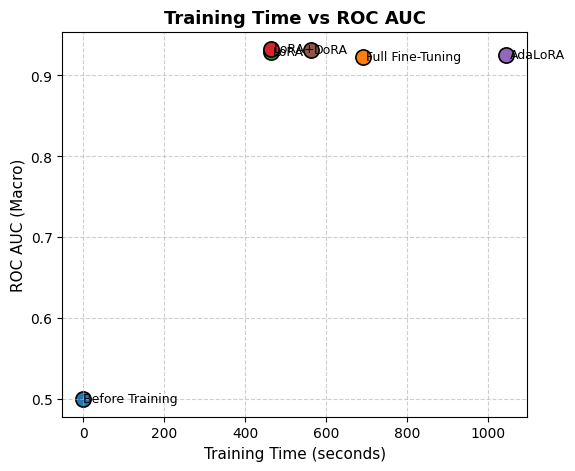

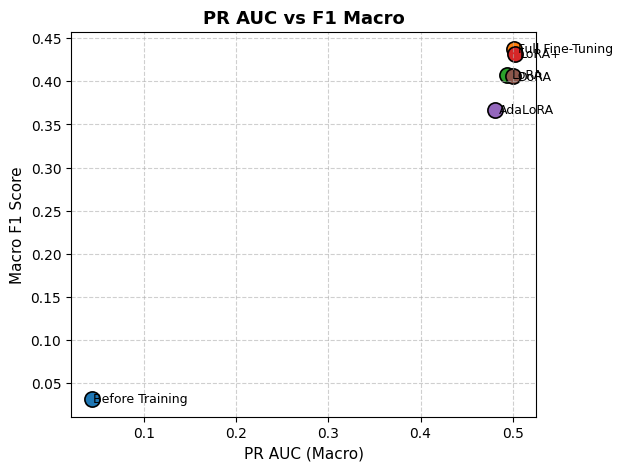

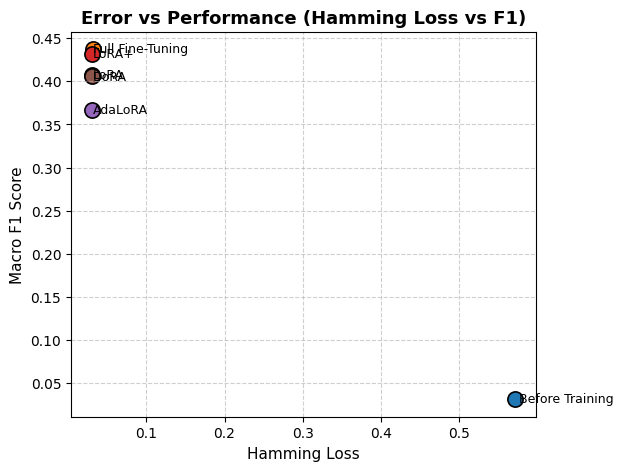

<Figure size 640x480 with 0 Axes>

In [28]:
import matplotlib.pyplot as plt

# Extract plotting data from results_table
methods = [r["Method"] for r in results_table]
params = [r.get("trainable_params", 0.0) / 1e6 for r in results_table]  # in millions
train_times = [r.get("train_time_sec", 0.0) for r in results_table]
f1_macros = [r.get("f1_macro", 0.0) for r in results_table]
roc_aucs = [r.get("roc_auc_macro", 0.0) for r in results_table]
pr_aucs = [r.get("pr_auc_macro", 0.0) for r in results_table]
hamming_losses = [r.get("hamming_loss", 0.0) for r in results_table]

plt.figure(figsize=(13, 5))
colors = plt.cm.tab10.colors

#  Plot 1: Training Time vs F1
plt.subplot(1, 2, 1)
for i, method in enumerate(methods):
    plt.scatter(train_times[i], f1_macros[i], s=120, label=method,
                color=colors[i % len(colors)], edgecolors='black', linewidth=1.2)
    plt.text(train_times[i]*1.01, f1_macros[i], method, fontsize=9, va='center')
plt.xlabel('Training Time (seconds)', fontsize=11)
plt.ylabel('Macro F1 Score', fontsize=11)
plt.title('Training Time vs Macro F1', fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 2: Parameters vs F1
plt.subplot(1, 2, 2)
for i, method in enumerate(methods):
    plt.scatter(params[i], f1_macros[i], s=120, label=method,
                color=colors[i % len(colors)], edgecolors='black', linewidth=1.2)
    plt.text(params[i]*1.01, f1_macros[i], method, fontsize=9, va='center')
plt.xlabel('Trainable Parameters (Millions)', fontsize=11)
plt.ylabel('Macro F1 Score', fontsize=11)
plt.title('Model Size vs Macro F1', fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)

# Plot 3. ROC AUC vs Training Time
plt.figure(figsize=(6,5))
for i, method in enumerate(methods):
    plt.scatter(train_times[i], roc_aucs[i], s=120, color=colors[i % len(colors)],
                edgecolors='black', linewidth=1.2)
    plt.text(train_times[i]*1.01, roc_aucs[i], method, fontsize=9, va='center')
plt.xlabel("Training Time (seconds)", fontsize=11)
plt.ylabel("ROC AUC (Macro)", fontsize=11)
plt.title("Training Time vs ROC AUC", fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot 4. PR AUC vs F1 Macro
plt.figure(figsize=(6,5))
for i, method in enumerate(methods):
    plt.scatter(pr_aucs[i], f1_macros[i], s=120, color=colors[i % len(colors)],
                edgecolors='black', linewidth=1.2)
    plt.text(pr_aucs[i]*1.01, f1_macros[i], method, fontsize=9, va='center')
plt.xlabel("PR AUC (Macro)", fontsize=11)
plt.ylabel("Macro F1 Score", fontsize=11)
plt.title("PR AUC vs F1 Macro", fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot 5. Hamming Loss vs F1
plt.figure(figsize=(6,5))
for i, method in enumerate(methods):
    plt.scatter(hamming_losses[i], f1_macros[i], s=120, color=colors[i % len(colors)],
                edgecolors='black', linewidth=1.2)
    plt.text(hamming_losses[i]*1.01, f1_macros[i], method, fontsize=9, va='center')
plt.xlabel("Hamming Loss", fontsize=11)
plt.ylabel("Macro F1 Score", fontsize=11)
plt.title("Error vs Performance (Hamming Loss vs F1)", fontsize=13, weight='bold')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# Plot 6. Radar Chart (Multi-Metric Comparison)
metrics = ["f1_macro", "precision_macro", "recall_macro", "roc_auc_macro", "pr_auc_macro"]
angles = np.linspace(0, 2*np.pi, len(metrics), endpoint=False).tolist()
angles += angles[:1]

plt.tight_layout()
plt.show()


# Optuna

Here we use Optuna to determine the optimal Learning Rate for both LoRA and Full Fine Tuning. Optuna creates a study where it dine tunes the model on a varying learning rate within a given range. These ranges are chosen based on general practice reccomendations. Here we use 10 trials to determine this hyperparameter. This could be increased for a more complete study and analysis. Optuna aims to maximise the F1 Macro score across the various iterations.

In [13]:
DEFAULT_R = 8
DEFAULT_ALPHA = 16
DEFAULT_DROPOUT = 0.1
OPT_EPOCHS = 1

def _run_trial_training(trial_method: str, lr: float, r: int = None, lora_alpha: int = None, lora_dropout: float = None):

    # 1. Load Base Model
    model = RobertaForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        problem_type="multi_label_classification",
    )

    if trial_method == "LoRA":
        config = LoraConfig(
            task_type=TaskType.SEQ_CLS,
            r=r,
            lora_alpha=lora_alpha,
            lora_dropout=lora_dropout,
            target_modules=["query", "value"],
        )
        model = get_peft_model(model, config)
        model.print_trainable_parameters()

    # 2. Setup Optimizer and Device
    model.to(DEVICE)
    optimizer = AdamW(model.parameters(), lr=lr)

    # 3. Train
    trained_model, _ = train_model(
        model,
        optimizer,
        trial_method,
        train_loader,
        DEVICE,
        OPT_EPOCHS,
        save_model=False
    )

    # 4. Evaluate
    eval_results = evaluate_model(
        trained_model,
        val_loader,
        f1_metric,
        THRESHOLD,
        DEVICE,
        trial_method
    )

    # 5. Cleanup
    cleanup(trained_model, optimizer)

    return eval_results["f1_macro"]

# STUDY 1: LoRA Learning Rate Optimization

def objective_lora_lr(trial):

    lr = trial.suggest_float('LEARNING_RATE_LoRA', 1e-6, 1e-4, log=True)

    r = DEFAULT_R
    lora_alpha = DEFAULT_ALPHA
    lora_dropout = DEFAULT_DROPOUT

    # Run the training
    f1_macro = _run_trial_training(
        trial_method='LoRA',
        lr=lr,
        r=r,
        lora_alpha=lora_alpha,
        lora_dropout=lora_dropout
    )

    trial.set_user_attr('lora_r', r)
    trial.set_user_attr('lora_alpha', lora_alpha)

    return f1_macro

print("\n" + "="*70)
print("STUDY 1: LoRA Learning Rate Optimization")
print(f"Fixed Parameters: r={DEFAULT_R}, alpha={DEFAULT_ALPHA}, dropout={DEFAULT_DROPOUT}")
print("="*70)

study_lora = optuna.create_study(direction='maximize', study_name="LoRA_LR_Study")
study_lora.optimize(objective_lora_lr, n_trials=10)

print("Done Lora")


# STUDY 2: Full Fine-Tuning Learning Rate Optimization

def objective_fullft_lr(trial):
    lr = trial.suggest_float('FF_LEARNING_RATE_FullFT', 5e-7, 5e-6, log=True)

    f1_macro = _run_trial_training(
        trial_method='Full Fine-Tuning',
        lr=lr
    )

    return f1_macro

print("\n" + "="*70)
print("STUDY 2: Full Fine-Tuning Learning Rate Optimization")
print("="*70)

study_fullft = optuna.create_study(direction='maximize', study_name="FullFT_LR_Study")
study_fullft.optimize(objective_fullft_lr, n_trials=10)

# LoRA Results
print("\n" + "#"*50)
print("BEST LoRA LEARNING RATE RESULT")
print("#"*50)
print(f"Best Macro F1: {study_lora.best_value:.4f}")
print(f"Optimal Learning Rate: {study_lora.best_params['LEARNING_RATE_LoRA']:.2e}")
print(f"Fixed Rank (r): {study_lora.best_trial.user_attrs['lora_r']}")
print(f"Fixed Alpha: {study_lora.best_trial.user_attrs['lora_alpha']}")
print("#"*50)

# --- Full Fine Tuning
print("\n" + "#"*50)
print("BEST FULL FINE-TUNING LEARNING RATE RESULT")
print("#"*50)
print(f"Best Macro F1: {study_fullft.best_value:.4f}")
print(f"Optimal Learning Rate: {study_fullft.best_params['FF_LEARNING_RATE_FullFT']:.2e}")
print("#"*50)

[I 2025-10-22 16:25:27,207] A new study created in memory with name: LoRA_LR_Study
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



STUDY 1: LoRA Learning Rate Optimization
Fixed Parameters: r=8, alpha=16, dropout=0.1
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:35<00:00, 17.50it/s, gpu_mem_gb=0.96, gpu_util_perc=93%, loss=0.0883]
[I 2025-10-22 16:28:12,491] Trial 0 finished with value: 0.0 and parameters: {'LEARNING_RATE_LoRA': 2.260170704583305e-06}. Best is trial 0 with value: 0.0.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.5456
Pr Auc Macro                  : 0.0514
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:34<00:00, 17.53it/s, gpu_mem_gb=0.96, gpu_util_perc=93%, loss=0.164]
[I 2025-10-22 16:30:57,571] Trial 1 finished with value: 0.3106389191419662 and parameters: {'LEARNING_RATE_LoRA': 5.273154921245257e-05}. Best is trial 1 with value: 0.3106389191419662.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.3106
F1 Micro                      : 0.5110
F1 Weighted                   : 0.4596
Precision Macro               : 0.5895
Recall Macro                  : 0.2574
Hamming Loss                  : 0.0319
Exact Match Accuracy          : 0.3830
Roc Auc Macro                 : 0.9061
Pr Auc Macro                  : 0.4364
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:34<00:00, 17.52it/s, gpu_mem_gb=0.96, gpu_util_perc=93%, loss=0.161]
[I 2025-10-22 16:33:42,663] Trial 2 finished with value: 0.0 and parameters: {'LEARNING_RATE_LoRA': 5.878022976411344e-06}. Best is trial 1 with value: 0.3106389191419662.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.6148
Pr Auc Macro                  : 0.0770
--------------------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:35<00:00, 17.47it/s, gpu_mem_gb=0.96, gpu_util_perc=91%, loss=0.18]
[I 2025-10-22 16:36:28,335] Trial 3 finished with value: 0.009724106739032111 and parameters: {'LEARNING_RATE_LoRA': 9.8626506903999e-06}. Best is trial 1 with value: 0.3106389191419662.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0097
F1 Micro                      : 0.0882
F1 Weighted                   : 0.0754
Precision Macro               : 0.0242
Recall Macro                  : 0.0061
Hamming Loss                  : 0.0410
Exact Match Accuracy          : 0.0525
Roc Auc Macro                 : 0.6830
Pr Auc Macro                  : 0.1080
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:36<00:00, 17.36it/s, gpu_mem_gb=0.96, gpu_util_perc=90%, loss=0.058]
[I 2025-10-22 16:39:14,990] Trial 4 finished with value: 0.22423809986347093 and parameters: {'LEARNING_RATE_LoRA': 3.496010303600127e-05}. Best is trial 1 with value: 0.3106389191419662.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.2242
F1 Micro                      : 0.4760
F1 Weighted                   : 0.4047
Precision Macro               : 0.3936
Recall Macro                  : 0.1918
Hamming Loss                  : 0.0331
Exact Match Accuracy          : 0.3472
Roc Auc Macro                 : 0.8813
Pr Auc Macro                  : 0.3907
--------------------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:35<00:00, 17.41it/s, gpu_mem_gb=0.96, gpu_util_perc=93%, loss=0.131]
[I 2025-10-22 16:42:01,178] Trial 5 finished with value: 0.0 and parameters: {'LEARNING_RATE_LoRA': 1.1589179134266898e-06}. Best is trial 1 with value: 0.3106389191419662.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.4985
Pr Auc Macro                  : 0.0436
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:35<00:00, 17.48it/s, gpu_mem_gb=0.96, gpu_util_perc=83%, loss=0.0699]
[I 2025-10-22 16:44:46,612] Trial 6 finished with value: 0.34016263254214124 and parameters: {'LEARNING_RATE_LoRA': 7.13611805890204e-05}. Best is trial 6 with value: 0.34016263254214124.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.3402
F1 Micro                      : 0.5151
F1 Weighted                   : 0.4708
Precision Macro               : 0.5831
Recall Macro                  : 0.2856
Hamming Loss                  : 0.0318
Exact Match Accuracy          : 0.3782
Roc Auc Macro                 : 0.9162
Pr Auc Macro                  : 0.4600
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:35<00:00, 17.50it/s, gpu_mem_gb=0.96, gpu_util_perc=94%, loss=0.207]
[I 2025-10-22 16:47:31,854] Trial 7 finished with value: 0.0 and parameters: {'LEARNING_RATE_LoRA': 1.7108445347364083e-06}. Best is trial 6 with value: 0.34016263254214124.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.5435
Pr Auc Macro                  : 0.0497
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:34<00:00, 17.54it/s, gpu_mem_gb=0.96, gpu_util_perc=93%, loss=0.17]
[I 2025-10-22 16:50:16,798] Trial 8 finished with value: 0.04200386982626463 and parameters: {'LEARNING_RATE_LoRA': 1.5378894333760126e-05}. Best is trial 6 with value: 0.34016263254214124.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0420
F1 Micro                      : 0.2282
F1 Weighted                   : 0.1769
Precision Macro               : 0.0790
Recall Macro                  : 0.0308
Hamming Loss                  : 0.0390
Exact Match Accuracy          : 0.1408
Roc Auc Macro                 : 0.7823
Pr Auc Macro                  : 0.2065
--------------------------------------------------
trainable params: 907,036 || all params: 125,574,200 || trainable%: 0.7223


LoRA Epoch 1: 100%|██████████| 2714/2714 [02:36<00:00, 17.33it/s, gpu_mem_gb=0.96, gpu_util_perc=91%, loss=0.119]
[I 2025-10-22 16:53:03,623] Trial 9 finished with value: 0.1658421304962574 and parameters: {'LEARNING_RATE_LoRA': 2.8666559324803324e-05}. Best is trial 6 with value: 0.34016263254214124.
[I 2025-10-22 16:53:03,624] A new study created in memory with name: FullFT_LR_Study
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| LoRA Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.1658
F1 Micro                      : 0.4261
F1 Weighted                   : 0.3513
Precision Macro               : 0.3788
Recall Macro                  : 0.1382
Hamming Loss                  : 0.0339
Exact Match Accuracy          : 0.2978
Roc Auc Macro                 : 0.8675
Pr Auc Macro                  : 0.3597
--------------------------------------------------
Done Lora

STUDY 2: Full Fine-Tuning Learning Rate Optimization


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s, gpu_mem_gb=2.35, gpu_util_perc=95%, loss=0.243]
[I 2025-10-22 16:57:02,889] Trial 0 finished with value: 0.0 and parameters: {'FF_LEARNING_RATE_FullFT': 5.282170800145767e-07}. Best is trial 0 with value: 0.0.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.5449
Pr Auc Macro                  : 0.0586
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s, gpu_mem_gb=2.35, gpu_util_perc=93%, loss=0.131]
[I 2025-10-22 17:01:02,128] Trial 1 finished with value: 0.054151165621356696 and parameters: {'FF_LEARNING_RATE_FullFT': 2.237305789241487e-06}. Best is trial 1 with value: 0.054151165621356696.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0542
F1 Micro                      : 0.3182
F1 Weighted                   : 0.2208
Precision Macro               : 0.0591
Recall Macro                  : 0.0500
Hamming Loss                  : 0.0367
Exact Match Accuracy          : 0.2130
Roc Auc Macro                 : 0.6757
Pr Auc Macro                  : 0.1767
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.82it/s, gpu_mem_gb=2.36, gpu_util_perc=96%, loss=0.183]
[I 2025-10-22 17:05:01,480] Trial 2 finished with value: 0.0 and parameters: {'FF_LEARNING_RATE_FullFT': 9.547848809315863e-07}. Best is trial 1 with value: 0.054151165621356696.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.6168
Pr Auc Macro                  : 0.0901
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s, gpu_mem_gb=2.36, gpu_util_perc=92%, loss=0.212]
[I 2025-10-22 17:09:00,673] Trial 3 finished with value: 0.0 and parameters: {'FF_LEARNING_RATE_FullFT': 1.3724220939071312e-06}. Best is trial 1 with value: 0.054151165621356696.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.5728
Pr Auc Macro                  : 0.0946
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.82it/s, gpu_mem_gb=2.36, gpu_util_perc=94%, loss=0.122]
[I 2025-10-22 17:12:59,991] Trial 4 finished with value: 0.0 and parameters: {'FF_LEARNING_RATE_FullFT': 1.1750379417478668e-06}. Best is trial 1 with value: 0.054151165621356696.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.5743
Pr Auc Macro                  : 0.0876
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s, gpu_mem_gb=2.36, gpu_util_perc=86%, loss=0.24]
[I 2025-10-22 17:16:59,155] Trial 5 finished with value: 0.0 and parameters: {'FF_LEARNING_RATE_FullFT': 7.0114768301313e-07}. Best is trial 1 with value: 0.054151165621356696.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0000
F1 Micro                      : 0.0000
F1 Weighted                   : 0.0000
Precision Macro               : 0.0000
Recall Macro                  : 0.0000
Hamming Loss                  : 0.0420
Exact Match Accuracy          : 0.0000
Roc Auc Macro                 : 0.5723
Pr Auc Macro                  : 0.0767
--------------------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s, gpu_mem_gb=2.36, gpu_util_perc=85%, loss=0.103]
[I 2025-10-22 17:20:58,450] Trial 6 finished with value: 0.10458376738065848 and parameters: {'FF_LEARNING_RATE_FullFT': 2.99909360318446e-06}. Best is trial 6 with value: 0.10458376738065848.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able 

--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.1046
F1 Micro                      : 0.3769
F1 Weighted                   : 0.2949
Precision Macro               : 0.1470
Recall Macro                  : 0.0865
Hamming Loss                  : 0.0347
Exact Match Accuracy          : 0.2551
Roc Auc Macro                 : 0.7462
Pr Auc Macro                  : 0.2403
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.81it/s, gpu_mem_gb=2.36, gpu_util_perc=95%, loss=0.119]
[I 2025-10-22 17:24:58,106] Trial 7 finished with value: 0.11871435425798871 and parameters: {'FF_LEARNING_RATE_FullFT': 3.3739089835967716e-06}. Best is trial 7 with value: 0.11871435425798871.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.1187
F1 Micro                      : 0.4294
F1 Weighted                   : 0.3283
Precision Macro               : 0.1475
Recall Macro                  : 0.1047
Hamming Loss                  : 0.0338
Exact Match Accuracy          : 0.3070
Roc Auc Macro                 : 0.7638
Pr Auc Macro                  : 0.2685
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.83it/s, gpu_mem_gb=2.36, gpu_util_perc=88%, loss=0.141]
[I 2025-10-22 17:28:57,357] Trial 8 finished with value: 0.09281395723625842 and parameters: {'FF_LEARNING_RATE_FullFT': 2.9255308448412556e-06}. Best is trial 7 with value: 0.11871435425798871.
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0928
F1 Micro                      : 0.3937
F1 Weighted                   : 0.2909
Precision Macro               : 0.1150
Recall Macro                  : 0.0815
Hamming Loss                  : 0.0351
Exact Match Accuracy          : 0.2816
Roc Auc Macro                 : 0.7166
Pr Auc Macro                  : 0.2372
--------------------------------------------------


Full Fine-Tuning Epoch 1: 100%|██████████| 2714/2714 [03:49<00:00, 11.82it/s, gpu_mem_gb=2.36, gpu_util_perc=95%, loss=0.226]
[I 2025-10-22 17:32:56,687] Trial 9 finished with value: 0.004585445869370713 and parameters: {'FF_LEARNING_RATE_FullFT': 1.4612555835014962e-06}. Best is trial 7 with value: 0.11871435425798871.


--------------------------------------------------
| Full Fine-Tuning Evaluation Results |
--------------------------------------------------
F1 Macro                      : 0.0046
F1 Micro                      : 0.0377
F1 Weighted                   : 0.0355
Precision Macro               : 0.0293
Recall Macro                  : 0.0025
Hamming Loss                  : 0.0414
Exact Match Accuracy          : 0.0217
Roc Auc Macro                 : 0.5705
Pr Auc Macro                  : 0.0956
--------------------------------------------------

##################################################
BEST LoRA LEARNING RATE RESULT
##################################################
Best Macro F1: 0.3402
Optimal Learning Rate: 7.14e-05
Fixed Rank (r): 8
Fixed Alpha: 16
##################################################

##################################################
BEST FULL FINE-TUNING LEARNING RATE RESULT
##################################################
Best Macro F1: 0.1187
Optimal Learnin